# Classification with standard parameters

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
import matplotlib as mpl
import os
from sklearn.model_selection import train_test_split

# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for ML
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

sns.set_style('whitegrid')

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Voting Classifiers

### Load data

In [2]:
DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513


### Drop not important features

In [3]:
print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009


### Split into train/test sets

In [4]:
X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Ensable learining with RandForest, LogReg, SVC

In [5]:
# Xgboost parameters
xgb_params = {'learning_rate': 0.05,
              'max_depth': 4,
              'subsample': 0.9,
              'colsample_bytree': 0.9,
              'objective': 'binary:logistic',
              'silent': 1,
              'n_estimators': 100,
              'gamma': 1,
              'min_child_weight': 4,
              # ENABLE GPU COMPUTING BY UNCOMMENTING BELOW
              #'gpu_id': 0,
              #'tree_method': 'gpu_hist'
             }
xgb_clf = XGBClassifier(**xgb_params, seed=10)
log_clf = LogisticRegression(
    solver="liblinear", random_state=42, multi_class='auto')
rnd_clf = RandomForestClassifier(n_estimators=3, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)
knn_clf = KNeighborsClassifier()

voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf), 
                ('lr', log_clf), 
                ('rf', rnd_clf),
                ('svc', svm_clf),
                ('knn', knn_clf)],
    voting='hard')

### Accuracy Scores for voting ensamble classifier (Hard voting)

In [6]:
# With scaled sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

for clf in (xgb_clf, log_clf, rnd_clf, svm_clf, knn_clf, voting_clf):
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

XGBClassifier 0.986
LogisticRegression 0.9432
RandomForestClassifier 0.9772
SVC 0.9464
KNeighborsClassifier 0.8968
VotingClassifier 0.9608


In [7]:
# Without scalint the sets
for clf in (xgb_clf, log_clf, rnd_clf, svm_clf, knn_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

XGBClassifier 0.9932
LogisticRegression 0.9396
RandomForestClassifier 0.986
SVC 0.8208
KNeighborsClassifier 0.7716
VotingClassifier 0.968


### CrossVal Scores without standardization

In [8]:
classifs = ['xgb_clf', 'log_clf', 'rnd_clf',
            'svm_clf', 'knn_clf', 'voting_clf']

def cv_learn(classificator_list, X_train, y_train, X_test, y_test,
             cv_size=5, scoring_type="accuracy", average_type="micro"):
    scores = []
    predictions = []
    matrices = []
    reports = []
        
    for clf in (classificator_list):
        # 5xCV
        y_scores = cross_val_score(clf, X_train, y_train,
                                      cv=cv_size, scoring=scoring_type)
        scores.append(y_scores)
        
        # Test Prediction
        pred = cross_val_predict(clf, X_test, y_test, cv=cv_size)
        predictions.append(pred)
        
        # Conf. Matrix
        matrices.append(confusion_matrix(y_test, pred))
        
        # CLF. Report
        reports.append(classification_report(y_test, pred))
        
    return (scores, predictions, matrices, reports)

In [9]:
classificator_list = [xgb_clf, log_clf, rnd_clf, svm_clf, knn_clf, voting_clf]

scores, predictions, matrices, reports = cv_learn(
    classificator_list, X_train, y_train, X_test, y_test)

xgb_clf
[0.98800799 0.98467688 0.99066667 0.98865911 0.993996  ]
Accuracy: 0.989 (+/- 0.006)
xgb_clf :
 [[1230    8    8]
 [  11  231    0]
 [   1    0 1011]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



log_clf
[0.93604264 0.93537642 0.958      0.94062708 0.93929286]
Accuracy: 0.942 (+/- 0.017)
log_clf :
 [[1109    1  136]
 [  26  215    1]
 [  49    0  963]]
              precision    recall  f1-score   support

      GALAXY       0.94      0.89      0.91      1246
         QSO       1.00      0.89      0.94       242
        STAR       0.88      0.95      0.91      1012

   micro avg       0.91      0.91      0.91      2500
   macro avg       0.94    

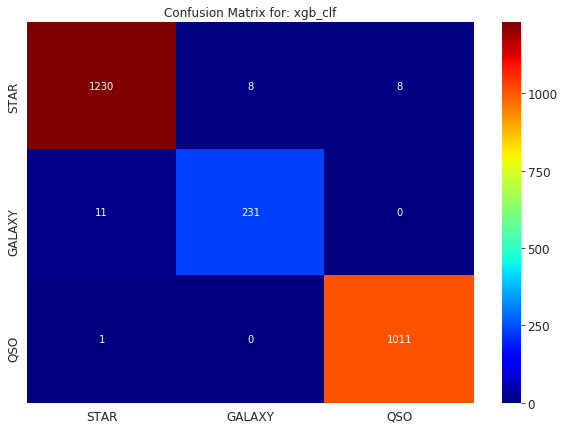

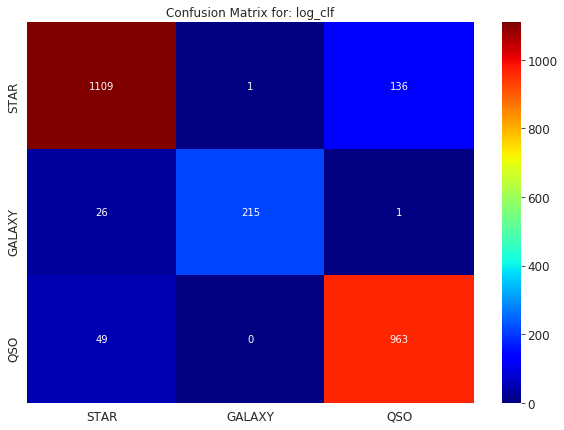

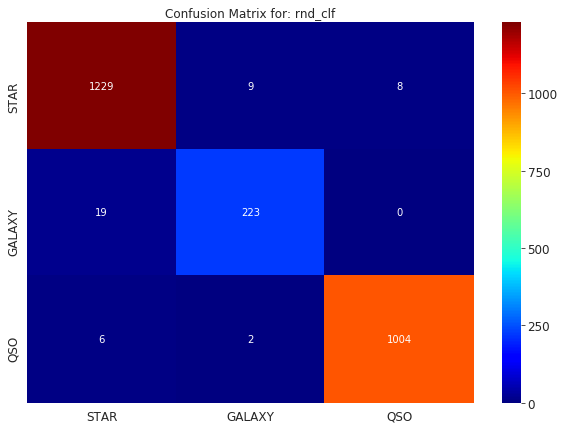

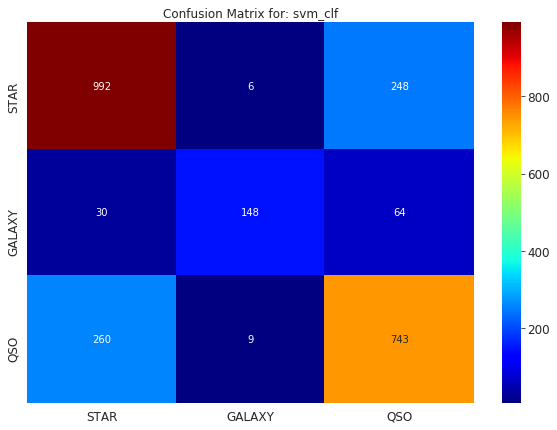

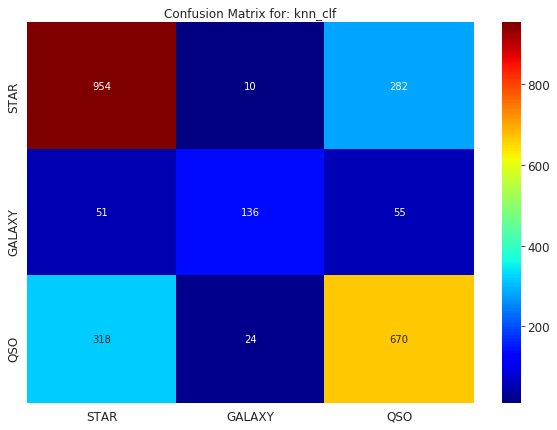

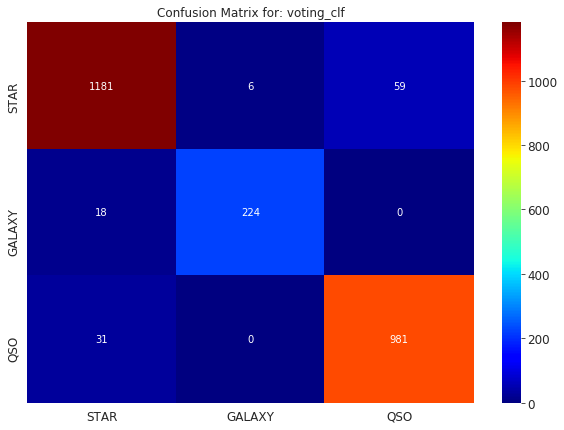

In [10]:
def print_cv_scores(scores):
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))


def print_conf_matrix(clf_name, matrix):
    print(clf_name, ":\n", matrix)


def plot_confusion_matrix(clf_name, class_names, cm, figsize):
    df_cm = pd.DataFrame(cm, index=[i for i in class_names],
                         columns=[i for i in class_names])
    plt.figure(figsize=figsize)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="jet").set_title(
        "Confusion Matrix for: " + str(clf_name))

def print_learning_results(classifs, class_names, scores, matrices, reports):
    for item in zip(classifs, scores, matrices, reports):
        print(item[0])
        print(item[1])
        print_cv_scores(item[1])
        print_conf_matrix(item[0], item[2])
        # Plot non-normalized confusion matrix
        plot_confusion_matrix(item[0], class_names, item[2], (10, 7))
        print(item[3])
        print("\n")

class_names = sdss_data["class"].unique()
        
print_learning_results(classifs, class_names, scores, matrices, reports)

### CrossVal Scores with standardization 

In [11]:
scores_scaled, predictions_scaled, matrices_scaled, reports_scaled = cv_learn(
    classificator_list, X_train_scaled, y_train, X_test_scaled, y_test)

xgb_clf
[0.98800799 0.98467688 0.99066667 0.98865911 0.993996  ]
Accuracy: 0.989 (+/- 0.006)
xgb_clf :
 [[1230    8    8]
 [  11  231    0]
 [   1    0 1011]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



log_clf
[0.94470353 0.94603598 0.96066667 0.95263509 0.94796531]
Accuracy: 0.950 (+/- 0.012)
log_clf :
 [[1128    3  115]
 [  25  217    0]
 [  34    0  978]]
              precision    recall  f1-score   support

      GALAXY       0.95      0.91      0.93      1246
         QSO       0.99      0.90      0.94       242
        STAR       0.89      0.97      0.93      1012

   micro avg       0.93      0.93      0.93      2500
   macro avg       0.94    

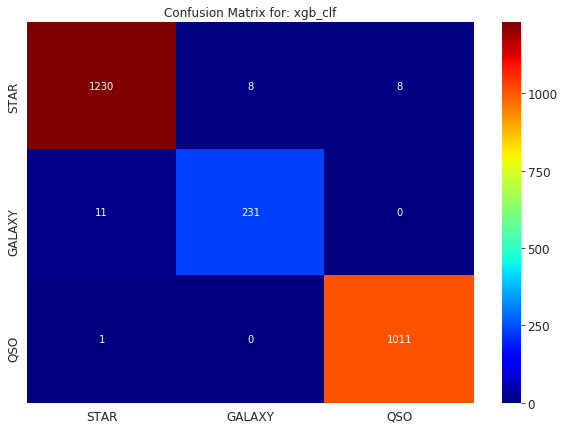

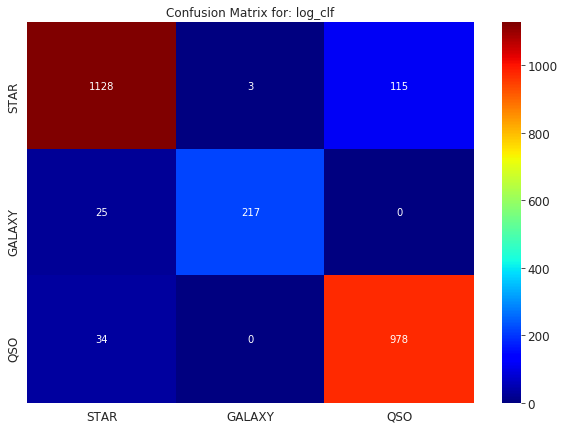

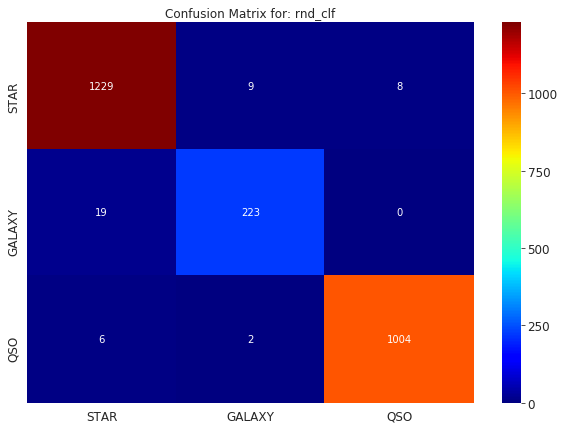

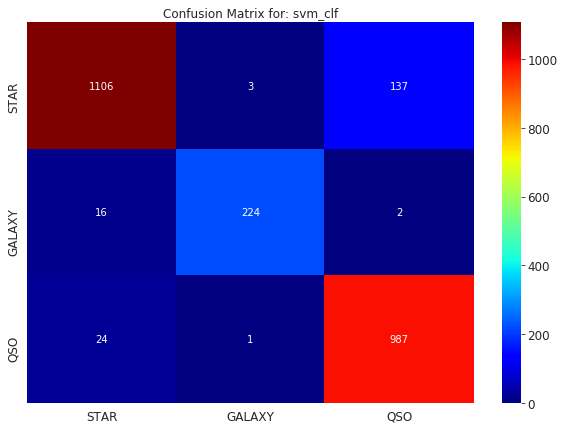

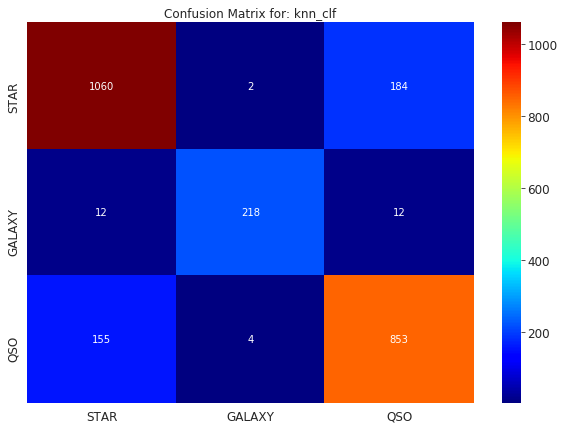

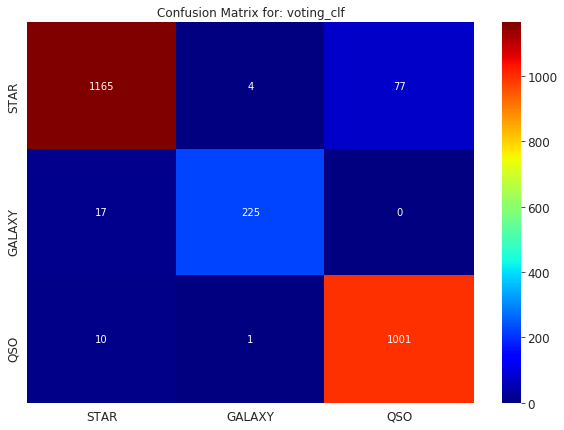

In [12]:
print_learning_results(classifs, class_names, scores_scaled, matrices_scaled, reports_scaled)